Original code from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py under the following license:

MIT License

Copyright (c) 2017 Erik Linder-Norén

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


The author's model was based on the paper here: https://arxiv.org/pdf/1511.06434.pdf

## Before you run this:
1. Install h5, with `pip3 install h5py`
1. Download the three h5 files: [generator](https://github.com/jennselby/MachineLearningTutorials/raw/master/generator.h5), [discriminator](https://github.com/jennselby/MachineLearningTutorials/raw/master/discriminator.h5), and [combined](https://github.com/jennselby/MachineLearningTutorials/raw/master/combined.h5) and save them in the same folder as this file.

In [3]:
%matplotlib inline

In [21]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.convolutional import UpSampling3D, Conv3D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

In [393]:
# Global Constants
images_dir = "dcgan_images_flags_small_4000"
img_rows = 10
img_cols = 16
channels = 3
noise_len = 100

img_shape = (img_rows, img_cols, channels)

## Define functions for creating, training, and using the models

In [32]:
def build_discriminator():
    '''
    Put together a CNN that will return a single confidence output.
    
    returns: the model object
    '''

    img_shape = (img_rows, img_cols, channels)

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [387]:
def build_generator():
    '''
    Put together a model that takes in one-dimensional noise and outputs two-dimensional data representing a black
    and white image, with -1 for black and 1 for white.
    
    returns: the model object
    '''

    noise_shape = (noise_len,)

    model = Sequential()

    model.add(Dense(128 * 4 * 5, activation="relu", input_shape=noise_shape))
    model.add(Reshape((5, 4, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(UpSampling2D(size = (1, 2)))
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

In [8]:
def build_combined():
    '''
    Puts together a model that combines the discriminator and generator models.
    
    returns: the generator, discriminator, and combined model objects
    '''
    
    optimizer = Adam(0.0002, 0.5)

    # Build and compile the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])


    # Build and compile the generator
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # The generator takes noise as input and generates images
    noise = Input(shape=(noise_len,))
    img = generator(noise)
    
    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    valid = discriminator(img)

    # The combined model  (stacked generator and discriminator) takes
    # noise as input => generates images => determines validity 
    combined = Model(inputs=noise, outputs=valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator, discriminator, combined

In [198]:
def save_imgs(generator, epoch):
    '''
    Has the generator create images and saves the images in a single file that includes the epoch in the filename.
    
    inputs:
        generator: the generator model object returned by build_combined
        epoch: the epoch number (but can be anything that can be represented as a string)
    
    returns: None
    '''
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_len))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    #fig.suptitle("DCGAN: Generated digits", fontsize=12)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(((gen_imgs[cnt, :,:,:] * 127.5) + 127.5).astype(np.uint8), vmax = 1, vmin=0)
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(images_dir, 'mnist_{}.png'.format(epoch)))
    plt.close()

In [378]:
def train(generator, discriminator, combined, epochs, batch_size=128, save_interval=50, img_gen = None):
    '''
    Trains all model objects
    
    generator: the generator model object returned by build_combined
    discriminator: the discriminator model object returned by build_combined
    combined: the combined model object returned by build_combined
    epochs: integer, the number of epochs to train for
    batch_size: integer, the number of training samples to use at a time
    save_interval: integer, will generate and save images when the current epoch % save_interval is 0
    
    returns: None
    '''

#     # Load the dataset
#     X_data, (_, _) = mnist.load_data()

#     X_train = []
#     for i in range(len(X_data[0])): # sorting out 4's
#         if X_data[1][i] == 4:
#             X_train.append(X_data[0][i])
            
#     X_train = np.array(X_train)

#     # Rescale -1 to 1
#     X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#     X_train = np.expand_dims(X_train, axis=3)
    
#     #inserting emoji images instead.
#     X_train = np.array(emojis)
#     X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    
    #inserting Flags images instead.
    X_train = np.array(flags_v2)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        
        if img_gen != None:
            imgs = [img_gen(img_shape) for i in range (half_batch)] # using geenerated images to train the GAN
            imgs = np.array(imgs)
            imgs = np.expand_dims(imgs, axis=3)
        else:
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
        
        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, noise_len))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, noise_len))

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # If at save interval => save generated image samples and plot progress
        if epoch % save_interval == 0:
            # Plot the progress
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print ("{} [D loss: {}, acc.: {:.2%}] [G loss: {}]".format(epoch, d_loss[0], d_loss[1], g_loss))
            save_imgs(generator, epoch)

In [188]:
def show_new_image(generator):
    '''
    Generates and displays a new image
    
    inputs: generator object model returned from build_combined
    
    returns: generated image
    '''
    
    noise = np.random.normal(0, 1, (1, noise_len))
    gen_img = ((generator.predict(noise)[0] * 127.5) + 127.5).astype(np.uint8)
    return plt.imshow(gen_img)

## Generating Images:

First Attempt at generating images:

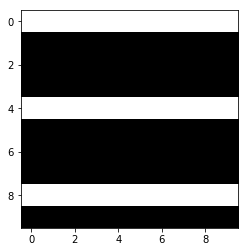

In [12]:

def gen_img_solid_horizontal(img_size, stripe_size = 1):
    img = []
    mod = np.random.randint(2, int((img_size[0]/2)))
    #print ("mod: " + str(mod))
    for i in range(int(img_size[1]/stripe_size)):
        color = -1
        if i % mod == 0:
            color = 1
        for i in range(stripe_size):
            img.append([color for i in range(img_size[0])])
    for i in range(img_size[1] % stripe_size):
        img.append([-1 for i in range(img_size[0])])
    return img

def gen_img_vary_horizontal(img_size, strp_size = 1):
    img = []
    mod = np.random.randint(2, int(img_size[0]/2))
    #print ("mod: " + str(mod))
    for i in range(img_size[1]):
        color = -1
        if i % mod == 0:
            color = np.random.randint(-100, 100)/100
        img.append([color for i in range(img_size[0])])
    return img

def gen_img_vary_vary_horizontal(img_size, strp_size = 1):
    img = []
    mod = np.random.randint(2, int(img_size[0]/2))
    #print ("mod: " + str(mod))
    for i in range(img_size[1]):
        if i % mod == 0:
            img.append([(np.random.randint(-100, 100)/100) for i in range(img_size[0])])
        else: 
            img.append([-1 for i in range(img_size[0])])
    return img

img = gen_img_solid_horizontal([10, 10], stripe_size = 1)
plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    

A simpler stripes Generation

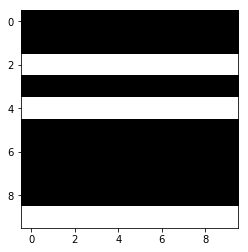

In [13]:
def gen_img_stripes(img_size):
    img = [np.random.randint(0, 2) for i in range(img_size[1])]
    img = [([1] * img_size[0] if i == 1 else [-1] * img_size[0]) for i in img]
    return img

    
img = gen_img_stripes([10, 10])
plt.imshow(img, cmap='gray', vmin=-1, vmax=1)

Code to generate crosses.

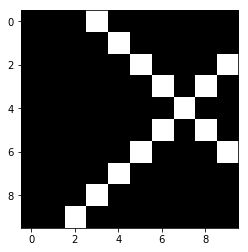

In [14]:
def gen_img_cross(img_size):
    coord = [np.random.randint(1, img_size[0] - 1), np.random.randint(1, img_size[1] - 1)]
    img = np.array([[-1 for n in range(img_size[0])] for i in range(img_size[1])])
    for i in range(img_size[1]):
        for n in range(img_size[0]):
            if abs(coord[1] - i) == abs(coord[0] - n):
                img[i][n] = 1
    return img

img = gen_img_cross([10, 10])
plt.imshow(img, cmap='gray', vmin=-1, vmax=1)

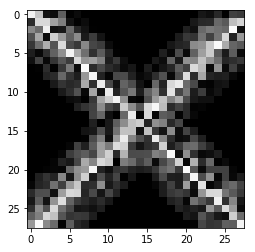

In [15]:
def gen_img_cross_big(img_size, grad = 4):
    coord = [int(img_size[0]/2), int((img_size[1]/2))]
    img = np.array([[-1.0 for n in range(img_size[0])] for i in range(img_size[1])])
    for i in range(img_size[1]):
        for n in range(img_size[0]):
            for k in reversed(range(1, int(max(img_size)/grad))):
                if abs(coord[1] - i) - k== abs(coord[0] - n):
                    img[i][n] = np.random.randint(-100, (100 - int(k * 200/(max(img_size)/grad))))/100
                if abs(coord[1] - i) + k== abs(coord[0] - n):
                    img[i][n] = np.random.randint(-100, (100 - int(k * 200/(max(img_size)/grad))))/100
            if abs(coord[1] - i) == abs(coord[0] - n):
                img[i][n] = np.random.randint(50, 100)/100
    return img

img = gen_img_cross_big([28, 28])
plt.imshow(img, cmap='gray', vmin=-1, vmax=1)

##  Importing and Formatting Flags

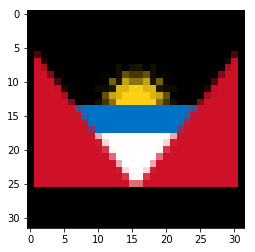

In [194]:
from PIL import Image as Image
from PIL import ImageOps as Image_op

flags = []
directory = os.fsencode("32x32_flat_flags")

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".png"): 
        img = Image.open(os.path.join(directory, os.fsencode(filename)))
        img = img.convert(mode = 'RGB')
        flags.append(np.array(img.getdata()).reshape(32, 32, 3).astype(np.uint8))
        

plt.imshow(flags[10], vmin = 0, vmax = 255)

In [588]:
from PIL import Image as Image
from PIL import ImageOps as Image_op

flags_v2 = []
flags_v2_names = []
directory = os.fsencode("16x10")

for folder in os.listdir(directory):
    if os.fsdecode(folder) != '.DS_Store':   
        for file in os.listdir(os.path.join(directory, folder)):
            filename = os.fsdecode(file)
            if filename.endswith(".png"): 
                img = Image.open(os.path.join(os.path.join(directory, folder), os.fsencode(filename)))
                img = img.convert(mode = 'RGB')
                flags_v2.append(np.array(img.getdata()).reshape(10, 16, 3).astype(np.uint8))
                flags_v2_names.append(filename)
        



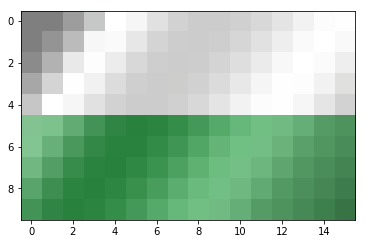

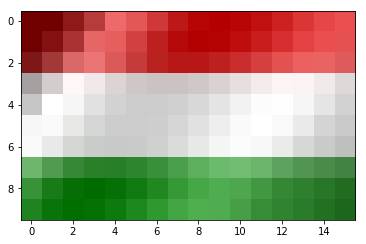

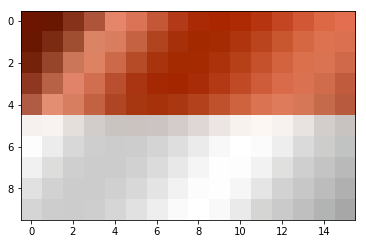

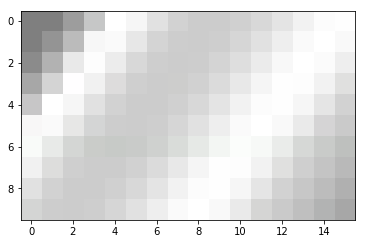

[63, 63, 63]
1271


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in ubyte_scalars
  del sys.path[0]


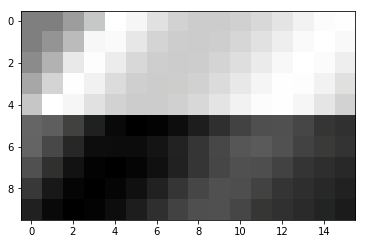

1312


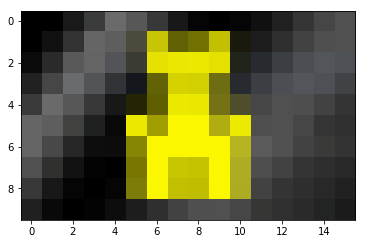

580


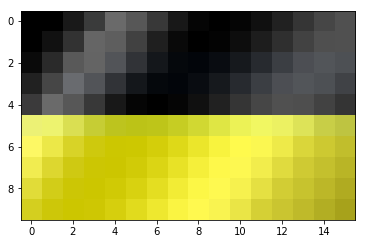

486


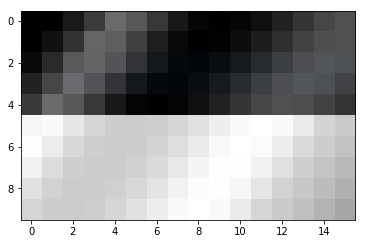

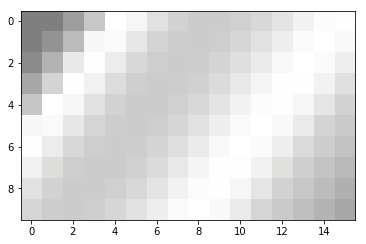

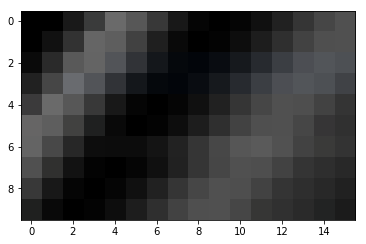

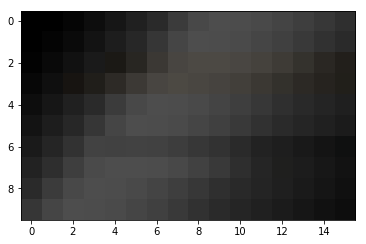

In [544]:
plt.imshow(flags_v2[610], vmin = 0, vmax = 255)
plt.show() # as seen from this demonstration the flags are made to seem 3d, now we need to make a mask to correct that bc I don't want that.
plt.imshow(flags_v2[106], vmin = 0, vmax = 255)
plt.show()
plt.imshow(flags_v2[107], vmin = 0, vmax = 255)
plt.show()
mask = np.concatenate((np.concatenate((flags_v2[610][0:4], flags_v2[106][4:7])), flags_v2[107][7:10]))
plt.imshow(mask, vmin = 0, vmax = 255)
plt.show()

mask = np.array(mask)

color = [int((mask.max() + mask.min())/2)]*3
print(color)
for i in range(len(mask)):
    for n in range(len(mask[i])):
        mask[i][n] = mask[i][n] - color

        
plt.imshow(mask, vmin = 0, vmax = 255)

print(flags_v2_names.index('pahang.png'))
plt.imshow(flags_v2[1271], vmin = 0, vmax = 255)
plt.show()
print(flags_v2_names.index('finnmark.png'))
plt.imshow(flags_v2[1312], vmin = 0, vmax = 255)
plt.show()
print(flags_v2_names.index('baden-wurttemberg.png'))
plt.imshow(flags_v2[580], vmin = 0, vmax = 255)
plt.show()
print(flags_v2_names.index('fribourg.png'))
plt.imshow(flags_v2[486], vmin = 0, vmax = 255)
plt.show()

mask_1 = np.concatenate((flags_v2[1271][0:5], flags_v2[486][5:10]))
plt.imshow(mask_1, vmin = 0, vmax = 255)
plt.show()
mask_2 = np.concatenate((flags_v2[486][0:5], flags_v2[1271][5:10]))
plt.imshow(mask_2, vmin = 0, vmax = 255)
plt.show()

mask_3 = []
for y in range(len(mask_1)):
    mask_3.append([])
    for x in range(len(mask_1[y])):
        mask_3[-1].append(np.array((mask_1[y][x] - mask_2[y][x])).astype(np.uint8))
        
mask = np.array(mask_3)
mask = mask - mask.min()
plt.imshow(mask, vmin = 0, vmax = 255)
plt.show()        


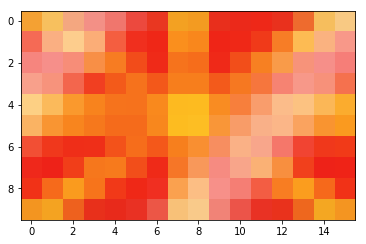

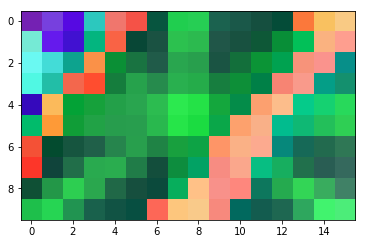

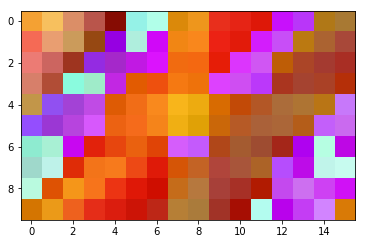

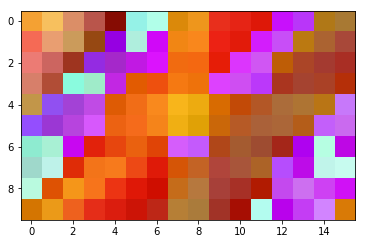

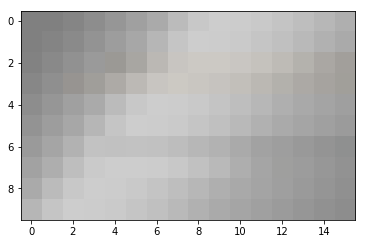

In [587]:
mask_1 = np.concatenate((flags_v2[1271][0:5], flags_v2[486][5:10]))
mask_3 = (mask_1 - mask_2)
flag = 150

plt.imshow(np.array(flags_v2[flag]), vmin = 0, vmax = 255)
plt.show()

flag_test = flags_v2[flag]

flag_test = 255 - ((mask_1 - flag_test ))
plt.imshow(flag_test, vmin = 0, vmax = 255)
plt.show()

flag_test = (flag_test + mask_3)
plt.imshow(flag_test, vmin = 0, vmax = 255)
plt.show()
flag_test = np.clip(flag_test, 0, 255)


plt.imshow(flag_test, vmin = 0, vmax = 255)
plt.show()
plt.imshow(mask_3, vmin = 0, vmax = 255)
plt.show()

## This is the main section of the code, that actually creates the model objects

In [394]:
# set up directories to hold the images that are saved during training checkpoints.
import os

if (not os.path.isdir(images_dir)):
    os.mkdir(images_dir)

In [395]:
# Uncomment if you wantto build your own new models
generator, discriminator, combined = build_combined()

**Make sure that you have downloaded the three h5 files before running the next block.**

In [41]:
# Load the saved model files. Comment out (or don't run) this block if you want to start with fresh models.
from keras.models import load_model

generator = load_model('generator.h5')
discriminator = load_model('discriminator.h5')
combined = load_model('combined.h5')

In [396]:
train(generator, discriminator, combined, epochs=4000, batch_size=32, save_interval=50)

/usr/local/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.887704074382782, acc.: 46.88%] [G loss: 0.42299389839172363]
50 [D loss: 0.5687198638916016, acc.: 75.00%] [G loss: 1.5523951053619385]
100 [D loss: 0.7873252630233765, acc.: 62.50%] [G loss: 1.4967310428619385]
150 [D loss: 0.7701621055603027, acc.: 53.12%] [G loss: 1.5822035074234009]
200 [D loss: 0.7039010524749756, acc.: 68.75%] [G loss: 1.6066005229949951]
250 [D loss: 0.4751797914505005, acc.: 75.00%] [G loss: 1.6190123558044434]
300 [D loss: 0.1784810721874237, acc.: 100.00%] [G loss: 2.3200302124023438]
350 [D loss: 0.42844158411026, acc.: 87.50%] [G loss: 1.3978766202926636]
400 [D loss: 0.7665106654167175, acc.: 53.12%] [G loss: 1.1048861742019653]
450 [D loss: 0.8289031982421875, acc.: 56.25%] [G loss: 1.1448922157287598]
500 [D loss: 0.6904113292694092, acc.: 62.50%] [G loss: 1.2740581035614014]
550 [D loss: 0.6159642934799194, acc.: 65.62%] [G loss: 1.1556471586227417]
600 [D loss: 0.7127884030342102, acc.: 56.25%] [G loss: 1.3481152057647705]
650 [D loss: 0.5

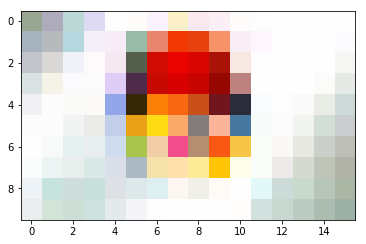

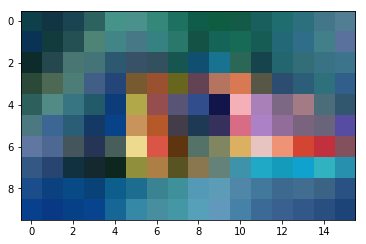

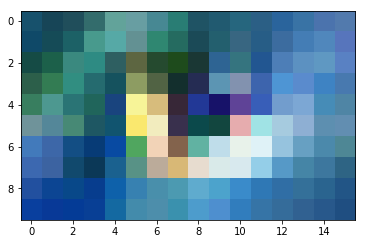

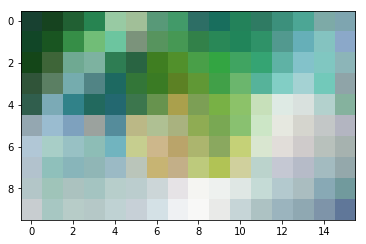

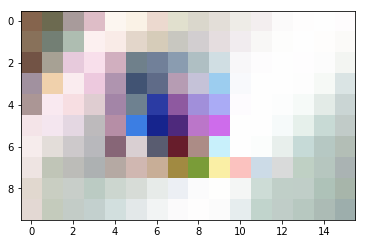

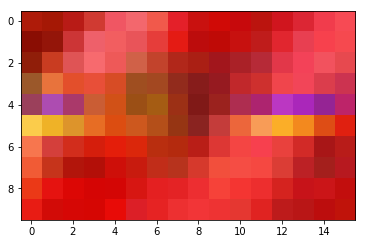

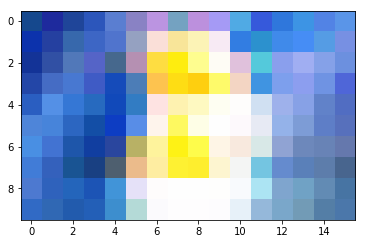

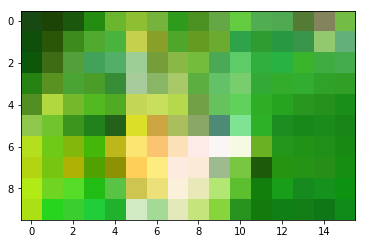

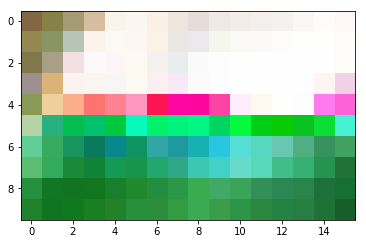

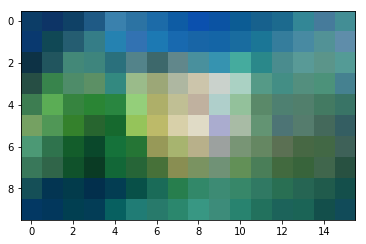

In [599]:
for i in range(0,10):
    show_new_image(generator)
    plt.show()

In [408]:
generator.save('generator_flag_small.h5')
discriminator.save('discriminator_flag_small.h5')
combined.save('combined_flag_small.h5')